# Dashboard

In [102]:
# export
import os
import numpy as np
import pandas as pd
import panel as pn
pn.extension('plotly')

import pyteomics.fasta
from io import StringIO
import plotly.graph_objects as go

from pepmap.importing import import_spectronaut_data
from pepmap.preprocessing import format_input_data
from pepmap.sequenceplot import plot_peptide_traces
from pepmap.uniprot_integration import uniprot_feature_dict
from pepmap.sequenceplot import uniprot_color_dict

In [103]:
path_to_folder_fasta_files = 'data'
full_fasta = None
full_uniprot = None

### Style of the dashboard

In [104]:
#export
css = '''

.bk-root .bk-btn-default.bk-active {
    background-color: #A2F5F5;
}

.bk.accordion {
    font-size: smaller;
}

.bk-root .bk-btn {
    padding: 6px 0px 6px 0px;
}

.bk.uniprot_options {
    margin: 16px 6px 16px 6px;
}

.bk-root .bk-btn-primary {
    background-color: #045082;
    font-size: 11px;
    font-weight: 700;
    text-transform: uppercase;
    letter-spacing: 1.5px;
}

.bk.card-title {
    font-size: 13px;
    font-weight: initial;
}

h1 {
    color: #045082;
    font-size: 45px;
    line-height: 0.6;
    text-align: center;
}

h4 {
    color: #173245;
    font-size: 18px;
    line-height: 0.6;
    text-align: center;
}

.codehilite {
    color: #173245;
    font-size: 14px;
    background-color: #eaeaea;
}

.codehilite .s2 {
    color: #173245;
    font-weight: bold;
}

.codehilite .ow {
    color: #045082;
    font-weight: initial;
}

.bk.opt {
    position: relative;
    display: block;
    left: 75px;
    top: 0px;
    width: 80px;
    height: 80px;
}

.bk.main-part {
    background-color: #EAEAEA;
    font-size: 17px;
    line-height: 23px;
    letter-spacing: 0px;
    font-weight: 500;
    color: #045082;
    text-align: center;
    position: relative !important;
    margin-left: auto;
    margin-right: auto;
    width: 40%;
}

.bk.selection_box {
    background-color: #EAEAEA;
}

'''
pn.extension(raw_css=[css])

### Header

In [105]:
### HEADER
header_titel = pn.pane.Markdown(
    '# AlphaMap', 
    width=1250,
    css_classes=['main_header'])
divider = pn.pane.HTML(
    '<hr style="height: 2px; border:none; background-color: #045082; width: 1480px">', 
    width=1500, 
    align='center'
)
mpi_biochem_logo = pn.pane.PNG(
    'data/img/mpi_logo.png', 
    link_url='https://www.biochem.mpg.de/en', 
    width=60, 
    height=60,
    align='start')
mpi_logo = pn.pane.JPG(
    'data/img/max-planck-gesellschaft.jpg', 
    link_url='https://www.biochem.mpg.de/en',
    height=62,
    embed=True,
    width=62,
    margin=(5, 0, 0, 5),
    css_classes=['opt'])

header = pn.Row(
    mpi_biochem_logo,
    mpi_logo,
    header_titel,
    height=80)

In [106]:
### WIDGETS
#####################################
# selectors
select_protein = pn.widgets.AutocompleteInput(
    name='Select a protein:', 
    placeholder='Type first letters of the protein id...',
    min_characters=1)
select_organism = pn.widgets.Select(
    name='Select an organism:', 
    value='Human', 
    options=['Human', 'Mouse', 'Arabidopsis'],
    margin=(0,0,0,7))

#####################################
# text
upload_file_text = pn.pane.Markdown(
    'Upload an experimental file:',
    margin=(10,0,-5,10))

#####################################
# all uploaded experimental data
experimental_data = pn.widgets.FileInput(
    accept=".csv, .txt", 
    margin=(-5,0,20,15))
experimental_data_2 = pn.widgets.FileInput(
    accept=".csv, .txt", 
    margin=(10,0,5,10))
experimental_data_3 = pn.widgets.FileInput(
    accept=".csv, .txt", 
    margin=(10,0,5,10))

#####################################
# all preprocessed experimental data
preprocessed_exp_data = pn.widgets.DataFrame(
    name='Exp_data')
preprocessed_exp_data_2 = pn.widgets.DataFrame(
    name='Exp_data_2')
preprocessed_exp_data_3 = pn.widgets.DataFrame(
    name='Exp_data_3')

#####################################
# buttons
upload_button = pn.widgets.Button(
    name='Upload  Data', 
    button_type='primary', 
    css_classes=['button_options'],
    height=40,
    width=150,
    align='center',
    margin=(0,0,50,0)
)
visualize_button = pn.widgets.Button(
    name='Visualize  Data', 
    button_type='primary', 
    css_classes=['button_options'],
    height=40,
    width=150,
    align='center',
    margin=(0,0,50,18)
)

In [107]:
### Experimental data card
additional_data_card = pn.Card(
    experimental_data_2,
    experimental_data_3,
    title='Upload additional experimental files',
    collapsed=True,
    width=300
)

In [108]:
### Options
options_preprocessing_events = pn.widgets.CheckButtonGroup(
    name='Molecule processing', 
    value=['Chain', 'Peptide'], 
    options=['Chain', 'Initiator methionine', 'Peptide', 'Propeptide', 'Signal peptide', 'Transit peptide'],
    align='center')
options_PTMs = pn.widgets.CheckButtonGroup(
    name='Post-translational modification', 
    options=['Cross-link', 'Disulfide bond', 'Glycosylation', 'Lipidation', 'Modified residue'],
    align='center')
options_domains = pn.widgets.CheckButtonGroup(
    name='Family & Domain',  
    options=['Coiled coil', 'Compositional bias', 'Domain', 'Motif', 'Region', 'Repeat', 'Zinc finger'],
    align='center')
options_locations = pn.widgets.CheckButtonGroup(
    name='Subcellular location', 
    options=['Intramembrane', 'Topological domain', 'Transmembrane'],
    align='center')
options_functions = pn.widgets.CheckButtonGroup(
    name='Function', 
    options=['Active site', 'Binding site', 'Calcium binding', 'DNA binding', 'Metal binding', 'Nucleotide binding', 'Site'],
    align='center')
options_sequences = pn.widgets.CheckButtonGroup(
    name='Sequence', 
    options=['Alternative sequence', 'Natural variant', 'Non-adjacent residues', 'Non-standard residue', 
             'Non-terminal residue', 'Sequence conflict', 'Sequence uncertainty'],
    align='center', )
options_other = pn.widgets.CheckButtonGroup(
    name='Other options', 
    options=['Secondary structure', 'Mutagenesis'],
    align='center')

uniprot_options = pn.Accordion(
    options_preprocessing_events, 
    options_PTMs,
    options_domains,
    options_locations,
    options_functions,
    options_sequences,
    options_other,
    active=list(range(0,7)),
    width = 850
)

uniprot_options_tab = pn.Accordion(
    ('Uniprot Options', 
     uniprot_options),
    width=860,
    css_classes=['uniprot_options'],
)

In [109]:
### PREPROCESSING
def upload_experimental_data():
    full_proteome_data = import_spectronaut_data(StringIO(str(experimental_data.value, "utf-8")))
    preprocessed_exp_data.value = format_input_data(
        df = full_proteome_data, 
        fasta = full_fasta, 
        modification_exp = r'\[.*?\]')
    select_protein.options = preprocessed_exp_data.value.unique_protein_id.unique().tolist()
    if experimental_data_2.filename:
        preprocessed_exp_data_2.value = format_input_data(
            df = import_spectronaut_data(StringIO(str(experimental_data_2.value, "utf-8"))), 
            fasta = full_fasta, 
            modification_exp = r'\[.*?\]')
    if experimental_data_3.filename:
        preprocessed_exp_data_3.value = format_input_data(
            df = import_spectronaut_data(StringIO(str(experimental_data_3.value, "utf-8"))), 
            fasta = full_fasta, 
            modification_exp = r'\[.*?\]')

def upload_organism_info():
    global full_fasta
    global full_uniprot
    if select_organism.value == 'Human':
        full_fasta = pyteomics.fasta.IndexedUniProt(os.path.join(path_to_folder_fasta_files, 
                                                                 "human.fasta"))
        full_uniprot = pd.read_csv(os.path.join(path_to_folder_fasta_files, 
                                                "preprocessed_uniprot_human.csv"))
    elif select_organism.value == 'Mouse':
        full_fasta = pyteomics.fasta.IndexedUniProt(os.path.join(path_to_folder_fasta_files, 
                                                                 "mouse.fasta"))
        full_uniprot = pd.read_csv(os.path.join(path_to_folder_fasta_files, 
                                                "preprocessed_uniprot_mouse.csv"))
    elif select_organism.value == 'Arabidopsis':
        full_fasta = pyteomics.fasta.IndexedUniProt(os.path.join(path_to_folder_fasta_files, 
                                                                 "arabidopsis_thaliana.fasta"))
        full_uniprot = pd.read_csv(os.path.join(path_to_folder_fasta_files, 
                                                "preprocessed_uniprot_arabidopsis.csv"))

In [110]:
### VISUALIZATION
@pn.depends(upload_button.param.clicks, 
            select_organism.param.value, 
            experimental_data.param.value)
def visualize_data(clicks, org, exp):
    if clicks > 0:
        # preload the data
        upload_organism_info()
        upload_experimental_data()
        # create a layout
        app = pn.Column(
            pn.Row(
                pn.layout.VSpacer(width=100),
                select_protein,
                pn.layout.VSpacer(width=80),
                uniprot_options_tab,
                aligh='center'
            ),
            pn.layout.HSpacer(height=30),
            visualize_button,
            divider,
            pn.Pane(
                visualize_plot, 
                aligh='center', 
                width=1500),
            margin=(20, 0)
        )
        return app

@pn.depends(visualize_button.param.clicks)
def visualize_plot(_):
    if select_protein.value:
        all_data = None
        all_names = None
        # combine selected uniprot options in one list
        uniprot_options_combined = sum([each.value for each in uniprot_options.objects if each.value], [])
        if all([experimental_data.filename, experimental_data_2.filename, experimental_data_3.filename]):
            all_data = [preprocessed_exp_data.value, 
                        preprocessed_exp_data_2.value, 
                        preprocessed_exp_data_3.value]
            all_names = [experimental_data.filename.split('.')[0],
                        experimental_data_2.filename.split('.')[0],
                        experimental_data_3.filename.split('.')[0]]
        elif experimental_data.filename and experimental_data_2.filename:
            all_data = [preprocessed_exp_data.value, preprocessed_exp_data_2.value]
            all_names = [experimental_data.filename.split('.')[0], 
                       experimental_data_2.filename.split('.')[0]]
        else:
            all_data = preprocessed_exp_data.value
            all_names = experimental_data.filename.split('.')[0]
        # create a main figure
        fig =  plot_peptide_traces(
            df = all_data,
            name = all_names,
            protein = select_protein.value,
            fasta = full_fasta, 
            uniprot = full_uniprot,
            selected_features = [uniprot_feature_dict[each] for each in uniprot_options_combined],
            uniprot_feature_dict = uniprot_feature_dict, 
            uniprot_color_dict = uniprot_color_dict)
        return fig

In [114]:
### MAIN PART
project_description = pn.pane.Markdown(
    '### This website enables the exploration of proteomic datasets on the peptide level. You can evaluate the sequence coverage of any selected protein and its identified post-translational modifications (PTMs). UniProt information is available to directly annotate sequence regions of interest such as protein domains, secondary structures, sequence variants, known PTMs, etc. ',
    margin=(30, 0, 5, 0), 
    css_classes=['main-part'], 
    width=615)

divider_descr = pn.pane.HTML(
    '<hr style="height: 8px; border:none; background-color: #045082; width: 620px">', 
    width=1510, 
    align='center'
)

project_instuction = pn.pane.Markdown(
    """#### How to use AlphaMap:
    1. Select the organism of your proteomic study.  
    2. Select up to 3 different bottom-up proteomic datasets analyzed  
    by AlphaPept, MaxQuant or Spectronaut.  
    3. Press the "Upload Data" button.  
    4. Select a protein of interest.  
    5. Select desired UniProt sequence annotations.  
    6. Press the "Visualize Data" button.  
    7. Enjoy exploring your data!  
    """,
    width=500,
    align='start',
    margin=(40, 80, 10, 10)
)

selection_box = pn.WidgetBox(
    select_organism,
    upload_file_text,
    experimental_data,
    additional_data_card,
    margin=(50, 150, 10, 80),
    width=300,
    css_classes=['selection_box'],
)

main_part = pn.Column(
    project_description,
    divider_descr,
    pn.Row(
        project_instuction,
        selection_box,
        align='center'
    ),
    upload_button,
    background='#eaeaea',
    width=1510,
    margin=(5, 0, 50, 0)
)

In [111]:
layout = pn.Column(
    header,
    main_part,
    visualize_data
)

Column
    [0] Row(sizing_mode='stretch_width')
        [0] PNG(str, height=60, link_url='https://www.biochem.mpg.d..., sizing_mode='fixed', width=60)
        [1] SVG(str, height=70, link_url='https://www.biochem.mpg.d..., sizing_mode='fixed', width=70)
        [2] Markdown(str, css_classes=['main_header'], width=1300)
    [1] Divider(align='center', margin=(5, 0), width=1500)
    [2] WidgetBox(css_classes=['run_analysis'], margin=10, width=300)
        [0] Select(margin=(0, 0, 0, 7), options=['Human', 'Mouse', ...], value='Human')
        [1] Markdown(str, margin=(10, 0, -5, 10))
        [2] FileInput(accept='.csv, .txt', margin=(-5, 0, 20, 15))
        [3] Card(collapsed=True, title='Upload additional e..., width=300)
            [0] FileInput(accept='.csv, .txt', margin=(10, 0, 5, 10))
            [1] FileInput(accept='.csv, .txt', margin=(10, 0, 5, 10))
    [3] Button(align='center', button_type='primary', css_classes=['button_options'], height=40, name='Upload  Data', sizing_mode='fixed', width=150)
    [4] Divider(align='center', margin=(5, 0), width=1500)
    [5] ParamFunction(function)
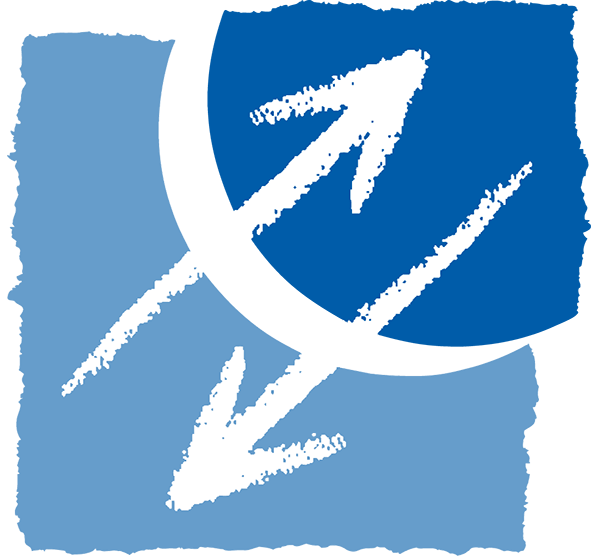

In [112]:
layout.servable()